In [161]:
import os, glob, time, datetime
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
import torch.nn as nn
from torchvision.utils import save_image

from common.dataset import TrainDataProvider
from common.function import init_embedding
from common.models import Encoder, Decoder, Discriminator, Generator
from common.utils import denorm_image

### GPU Option

In [2]:
GPU = torch.cuda.is_available()
GPU

True

### Path Setting

In [3]:
data_dir = './dataset/'
model_dir = './model_save/'
fixed_dir = './fixed_sample'

### Get Fixed Embedding

In [4]:
embeddings = torch.load(os.path.join(fixed_dir, 'EMBEDDINGS.pkl'))
embeddings.shape

torch.Size([100, 1, 1, 128])

### Hyper Parameter Setting

In [5]:
FONTS_NUM = 25
EMBEDDING_NUM = 100
BATCH_SIZE = 16
IMG_SIZE = 128
EMBEDDING_DIM = 128

### Ground Truth Target - 50epoch / 59epoch

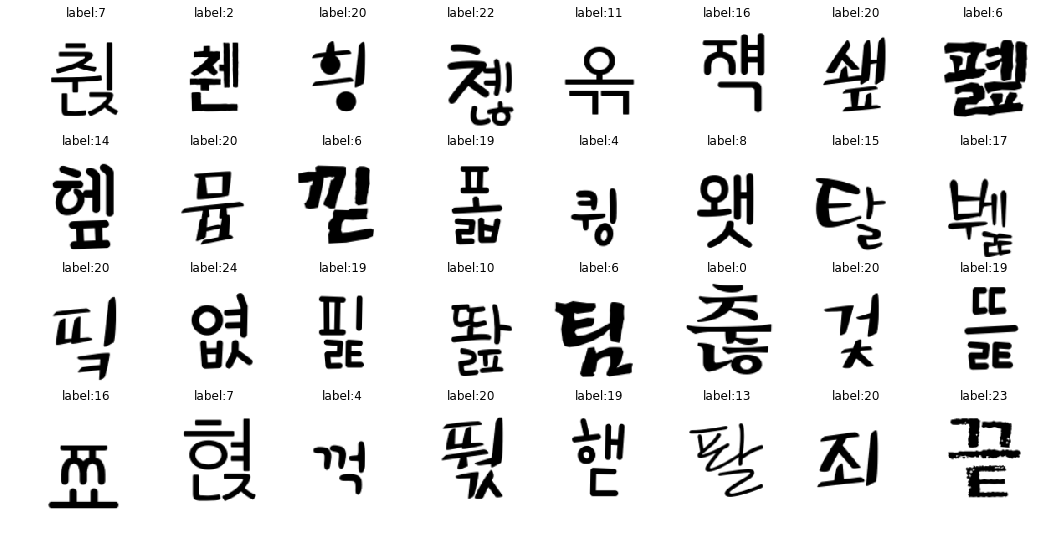

In [26]:
fixed_dir = './fixed_sample/'
fixed_target_all = torch.load(os.path.join(fixed_dir, 'fixed_target_all.pkl'))
fixed_label_all = np.array(torch.load(os.path.join(fixed_dir, 'fixed_label_all.pkl')).cpu())

plt.figure(figsize=(18, 9))
for idx, image in enumerate(fixed_target_all):
    plt.subplot(4, 8, idx+1)
    plt.imshow(image.reshape(128, 128).cpu().numpy(), cmap='gray')
    plt.title("label:" + str(fixed_label_all[idx]))
    plt.axis('off')
plt.show()

### 50epoch 결과

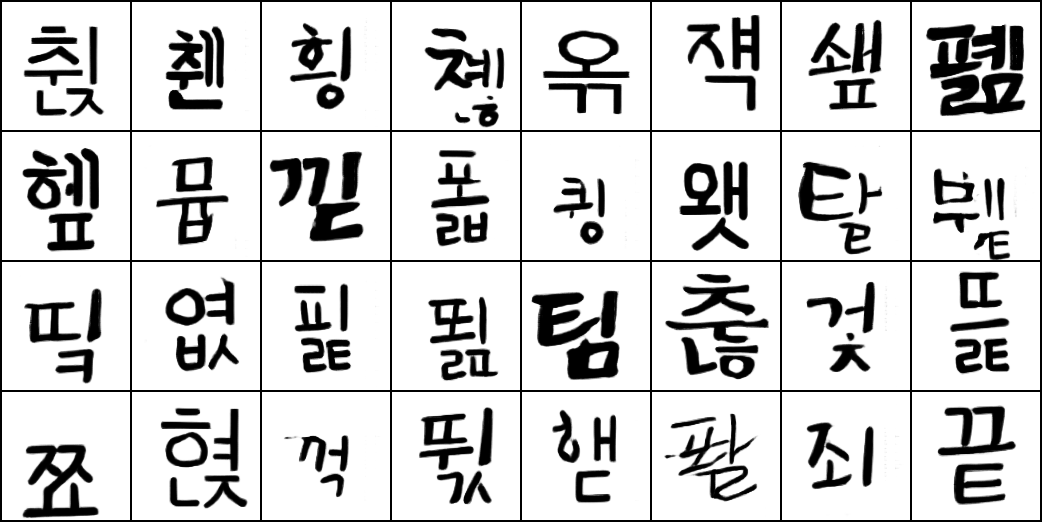

In [27]:
im = Image.open('fixed_fake_fail_60/fake_samples-50-5000.png')
im

### 59epoch 결과

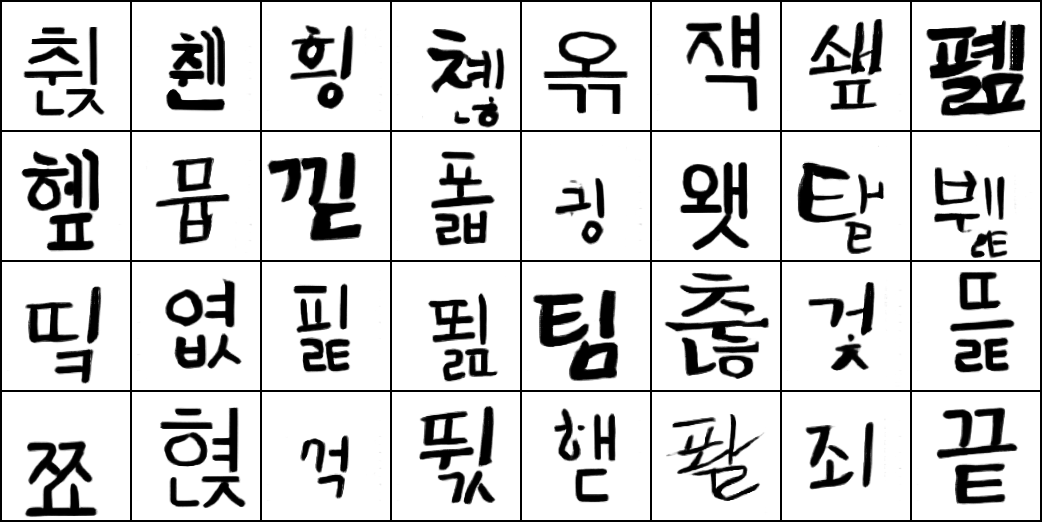

In [28]:
im2 = Image.open('fixed_fake_fail_60/fake_samples-59-5000.png')
im2

- 일단, 50epoch 와 59epoch 간에는 큰 차이가 없는 것으로 보인다. 


- 따라서 60epoch 에서 발산을 하기도 했으니 그냥 똑같은 학습은 일단 그만 시키는 것으로 한다.


- 각 폰트들의 상황을 모두 확인 해 본 다음, 잘 학습이 안된 폰트만 세부 튜닝을 들어간다

## 각 폰트마다 상황 보기

### Get Fixed sample

In [29]:
fixed_dir = './fixed_sample'

In [30]:
fixed_sources, fixed_targets, fixed_labels = [], [], []

# font별 fixed target
for i in range(25):
    source = torch.load(os.path.join(fixed_dir, 'fixed_source_%d.pkl' % i))
    target = torch.load(os.path.join(fixed_dir, 'fixed_target_%d.pkl' % i))
    label = torch.load(os.path.join(fixed_dir, 'fixed_label_%d.pkl' % i))
    fixed_sources.append(source)
    fixed_targets.append(target)
    fixed_labels.append(label)
    
# 모든 폰트가 섞여있는 target
source = torch.load(os.path.join(fixed_dir, 'fixed_source_all.pkl'))
target = torch.load(os.path.join(fixed_dir, 'fixed_target_all.pkl'))
label = torch.load(os.path.join(fixed_dir, 'fixed_label_all.pkl'))
fixed_sources.append(source)
fixed_targets.append(target)
fixed_labels.append(label)

print("fixed sources:", len(fixed_sources))
print("fixed targets:", len(fixed_targets))
print("fixed labels:", len(fixed_labels))

fixed sources: 26
fixed targets: 26
fixed labels: 26


### Model import

In [31]:
En = Encoder().cuda()
De = Decoder().cuda()
D = Discriminator(category_num=FONTS_NUM).cuda()
from_model_path = './model_checkpoint/'
encoder_path = '25-0526-01:41-Encoder.pkl'
decoder_path = '25-0526-01:41-Decoder.pkl'
discriminator_path = '25-0526-01:41-Discriminator.pkl'

En.load_state_dict(torch.load(os.path.join(from_model_path, encoder_path)))
De.load_state_dict(torch.load(os.path.join(from_model_path, decoder_path)))
D.load_state_dict(torch.load(os.path.join(from_model_path, discriminator_path)))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

---

# Font 1

### sources

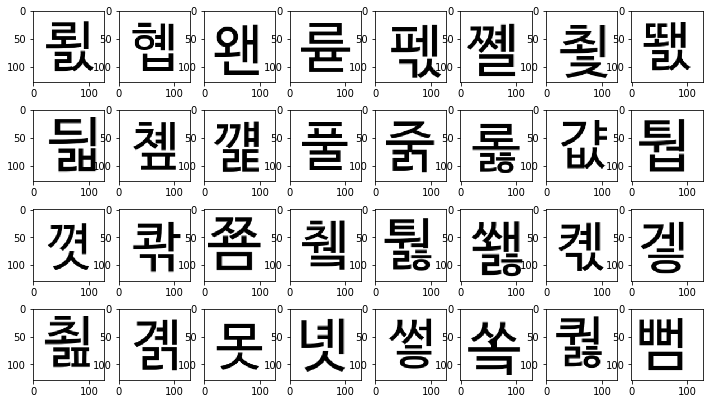

In [49]:
plt.figure(figsize=(12, 7))
for idx, image in enumerate(fixed_sources[0]):
    plt.subplot(4, 8, idx+1)
    plt.imshow(image.reshape(128, 128).cpu().numpy(), cmap='gray')
plt.show()

### labels

In [33]:
fixed_labels[0]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

### targets

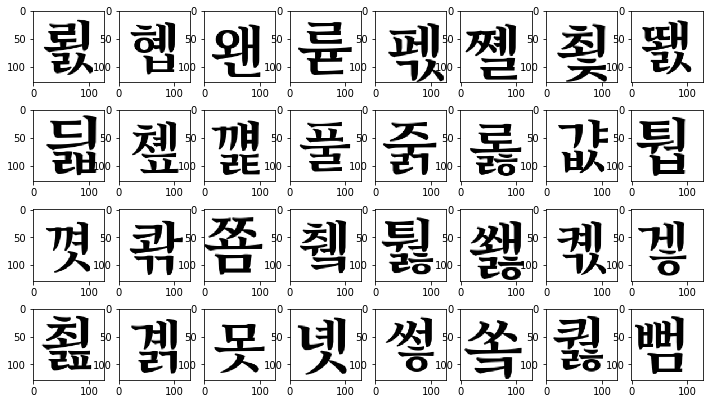

In [36]:
plt.figure(figsize=(12, 7))
for idx, image in enumerate(fixed_targets[0]):
    plt.subplot(4, 8, idx+1)
    plt.imshow(image.reshape(128, 128).cpu().numpy(), cmap='gray')
plt.show()

### generated fake targets

In [63]:
a = torch.tensor(np.arange(32))

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

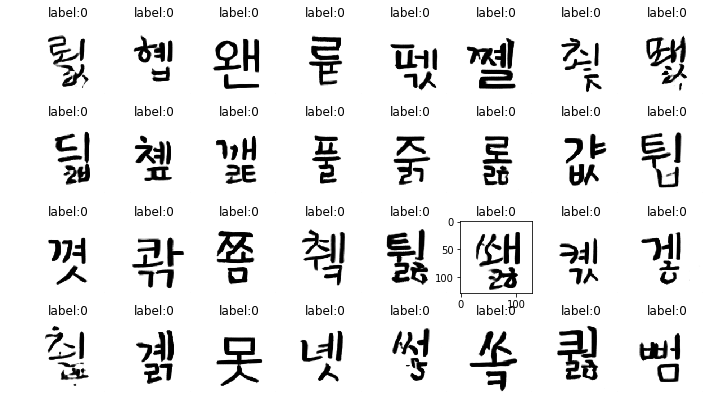

In [61]:
fixed_fake_images_1 = Generator(fixed_sources[0], En, De, embeddings, fixed_labels[0], GPU=GPU)[0]

plt.figure(figsize=(12, 7))
for idx, image in enumerate(fixed_fake_images_1):
    plt.subplot(4, 8, idx+1)
    plt.imshow(image.reshape(128, 128).cpu().detach().numpy(), cmap='gray')
    plt.title("label:" + str(int(fixed_labels[0][idx].cpu().data)))
    if idx != 21:
        plt.axis('off')
plt.show()

- 이상한 결과 발생. label에 안맞는 폰트가 생성된다. 왜????

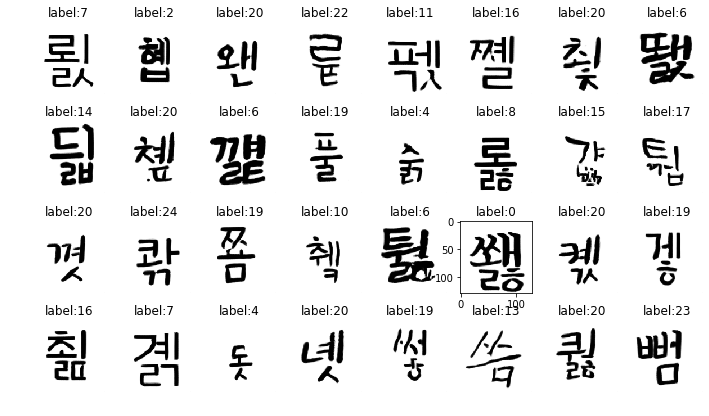

In [62]:
fixed_fake_images_1 = Generator(fixed_sources[0], En, De, embeddings, fixed_labels[-1], GPU=GPU)[0]

plt.figure(figsize=(12, 7))
for idx, image in enumerate(fixed_fake_images_1):
    plt.subplot(4, 8, idx+1)
    plt.imshow(image.reshape(128, 128).cpu().detach().numpy(), cmap='gray')
    plt.title("label:" + str(int(fixed_labels[-1][idx].cpu().data)))
    if idx != 21:
        plt.axis('off')
plt.show()

### 급나 이상한 상황 발생 : `쐟`
같은 source에 같은 label로 generating 했는데 다른 결과가 나온다.  
그니까, label이 여러개 섞여있는 `fixed_labels[-1]`로 generating 할 때는 좀 말이 되는 결과가 나오는데,  
label을 다 0으로 해서 생성할 때는 말 안되는 결과가 나옴.

### fixed_sources[0]의 21번을 32개 복제 해서 testing

In [131]:
test_source_1 = torch.tensor(np.array([fixed_sources[0][21].cpu().numpy() for i in range(32)])).cuda()
test_source_1.shape

torch.Size([32, 1, 128, 128])

In [132]:
np.all((test_source_1[0] == test_source_1[10]).cpu().numpy())

True

In [133]:
test_label_1 = torch.tensor(np.array([fixed_labels[0][21].cpu().numpy() for i in range(32)])).cuda()
test_label_1

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

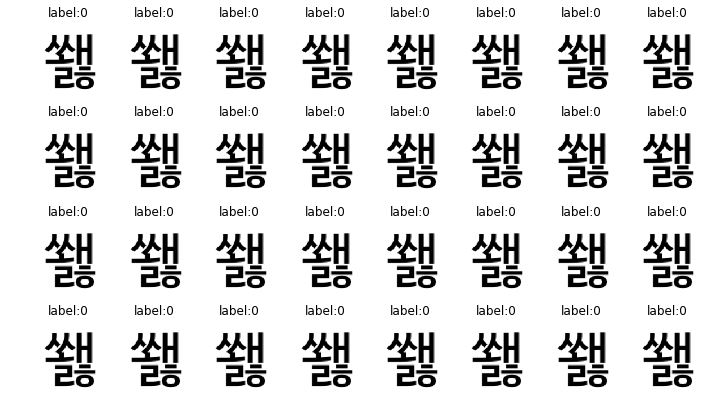

In [142]:
plt.figure(figsize=(12, 7))
for idx, image in enumerate(test_source_1):
    plt.subplot(4, 8, idx+1)
    plt.imshow(image.reshape(128, 128).cpu().detach().numpy(), cmap='gray')
    plt.title("label:" + str(int(test_label_1[idx].cpu().data)))
    plt.axis('off')
plt.show()

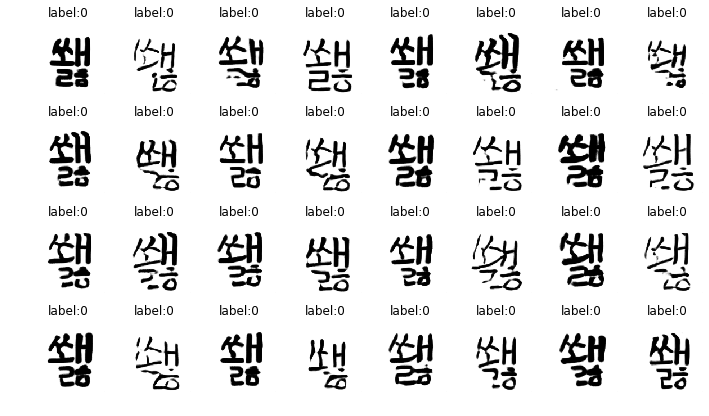

In [134]:
test_fake = Generator(test_source_1, En, De, embeddings, test_label_1, GPU=GPU)[0]

plt.figure(figsize=(12, 7))
for idx, image in enumerate(test_fake):
    plt.subplot(4, 8, idx+1)
    plt.imshow(image.reshape(128, 128).cpu().detach().numpy(), cmap='gray')
    plt.title("label:" + str(int(test_label_1[idx].cpu().data)))
    plt.axis('off')
plt.show()

### 어디서 달라지는 건지 찾아내기

`Generator(test_source_1, En, De, embeddings, test_label_1, GPU=GPU)[0]` 

- 위에서 test_source_1, test_label_1은 둘다 똑같은 값인데 결과값이 다 다른 이유.

In [155]:
from common.function import embedding_lookup

def Generator(images, En, De, embeddings, embedding_ids, GPU=False):
    encoded_source, encode_layers = En(images)
    local_embeddings = embedding_lookup(embeddings, embedding_ids, GPU=GPU)
    if GPU:
        encoded_source = encoded_source.cuda()
        local_embeddings = local_embeddings.cuda()
    embedded = torch.cat((encoded_source, local_embeddings), 1)
    fake_target = De(embedded, encode_layers)
    return fake_target, encoded_source

In [208]:
encoded_source_1, encode_layers_1 = En(test_source_1)

In [209]:
for i in range(32):
    print(np.sum(encoded_source_1[i].cpu().detach().numpy()), end="\t")
    if (i+1) % 4 == 0:
        print("")

-150.24057	-149.40427	-150.24057	-149.40427	
-150.24057	-149.40427	-150.24057	-149.40427	
-150.24057	-149.40427	-150.24057	-149.40427	
-150.24057	-149.40427	-150.24057	-149.40427	
-150.24057	-149.40427	-150.24057	-149.40427	
-150.24057	-149.40427	-150.24057	-149.40427	
-150.24057	-149.40427	-150.24057	-149.40427	
-150.24057	-149.40427	-150.24057	-149.40427	


In [210]:
print(encoded_source_1[0][:5].squeeze().data)
print(encoded_source_1[2][:5].squeeze().data)
print(encoded_source_1[4][:5].squeeze().data)
print(encoded_source_1[6][:5].squeeze().data)

tensor([-0.1527, -0.1272, -0.0981, -0.3281, -0.1926], device='cuda:0')
tensor([-0.1527, -0.1272, -0.0981, -0.3281, -0.1926], device='cuda:0')
tensor([-0.1527, -0.1272, -0.0981, -0.3281, -0.1926], device='cuda:0')
tensor([-0.1527, -0.1272, -0.0981, -0.3281, -0.1926], device='cuda:0')


In [211]:
print(encoded_source_1[1][:5].squeeze().data)
print(encoded_source_1[3][:5].squeeze().data)
print(encoded_source_1[5][:5].squeeze().data)
print(encoded_source_1[7][:5].squeeze().data)

tensor([-0.1899, -0.0855, -0.1060, -0.3088, -0.1858], device='cuda:0')
tensor([-0.1899, -0.0855, -0.1060, -0.3088, -0.1858], device='cuda:0')
tensor([-0.1899, -0.0855, -0.1060, -0.3088, -0.1858], device='cuda:0')
tensor([-0.1899, -0.0855, -0.1060, -0.3088, -0.1858], device='cuda:0')


#### 뭐지? 짝수 / 홀수 값만 같다

In [215]:
local_embeddings_1 = embedding_lookup(embeddings, test_label_1, GPU=GPU)
local_embeddings_1.squeeze()

tensor([[-0.0110,  0.0011, -0.0050,  ..., -0.0041, -0.0096, -0.0056],
        [-0.0110,  0.0011, -0.0050,  ..., -0.0041, -0.0096, -0.0056],
        [-0.0110,  0.0011, -0.0050,  ..., -0.0041, -0.0096, -0.0056],
        ...,
        [-0.0110,  0.0011, -0.0050,  ..., -0.0041, -0.0096, -0.0056],
        [-0.0110,  0.0011, -0.0050,  ..., -0.0041, -0.0096, -0.0056],
        [-0.0110,  0.0011, -0.0050,  ..., -0.0041, -0.0096, -0.0056]],
       device='cuda:0')

In [218]:
embedded_1 = torch.cat((encoded_source_1, local_embeddings_1), 1)
embedded_1.squeeze()

tensor([[-0.1527, -0.1272, -0.0981,  ..., -0.0041, -0.0096, -0.0056],
        [-0.1899, -0.0855, -0.1060,  ..., -0.0041, -0.0096, -0.0056],
        [-0.1527, -0.1272, -0.0981,  ..., -0.0041, -0.0096, -0.0056],
        ...,
        [-0.1899, -0.0855, -0.1060,  ..., -0.0041, -0.0096, -0.0056],
        [-0.1527, -0.1272, -0.0981,  ..., -0.0041, -0.0096, -0.0056],
        [-0.1899, -0.0855, -0.1060,  ..., -0.0041, -0.0096, -0.0056]],
       device='cuda:0', grad_fn=<SqueezeBackward0>)

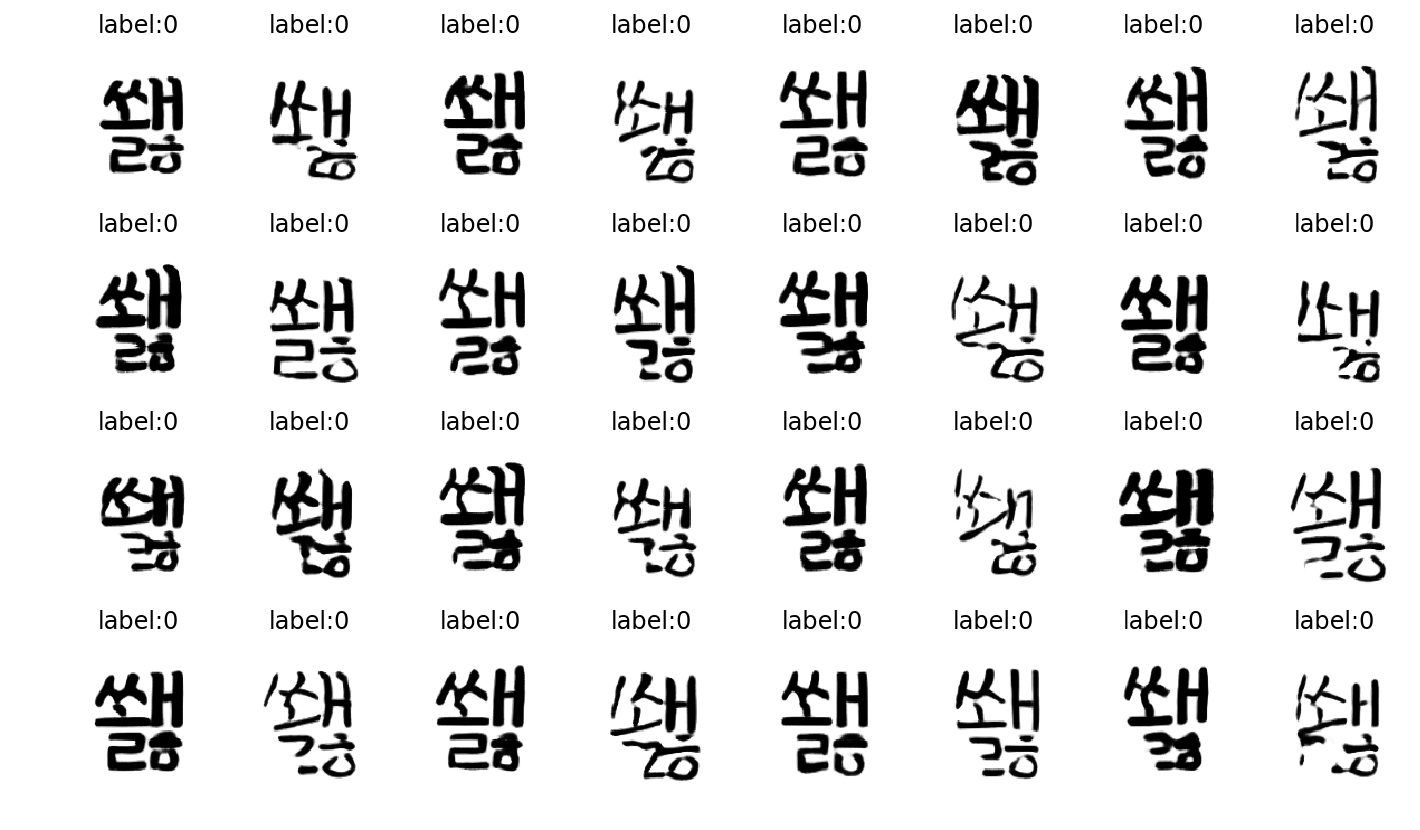

In [221]:
fake_target_1 = De(embedded_1, encode_layers_1)

plt.figure(figsize=(12, 7))
for idx, image in enumerate(fake_target_1):
    plt.subplot(4, 8, idx+1)
    plt.imshow(image.reshape(128, 128).cpu().detach().numpy(), cmap='gray')
    plt.title("label:" + str(int(test_label_1[idx].cpu().data)))
    plt.axis('off')
plt.show()

### 여기서 너무 달라지는 이유는?

---

### fixed_sources[-1]의 21번을 32개 복제 해서 testing

In [135]:
test_source_2 = torch.tensor(np.array([fixed_sources[-1][21].cpu().numpy() for i in range(32)])).cuda()
test_source_2.shape

torch.Size([32, 1, 128, 128])

In [136]:
np.all((test_source_2[0] == test_source_2[10]).cpu().numpy())

True

In [137]:
test_label_2 = torch.tensor(np.array([fixed_labels[-1][21].cpu().numpy() for i in range(32)])).cuda()
test_label_2

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

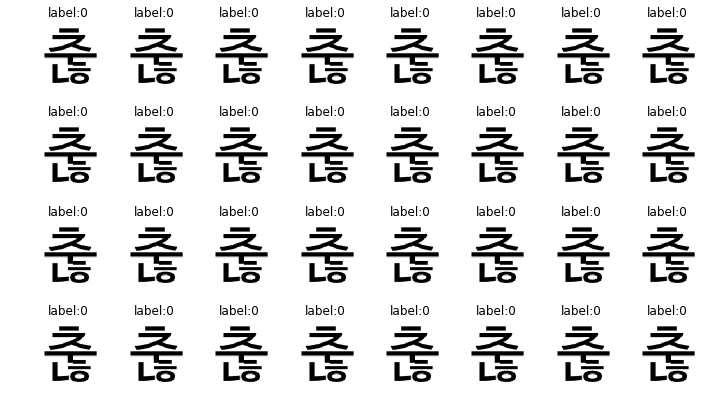

In [140]:
plt.figure(figsize=(12, 7))
for idx, image in enumerate(test_source_2):
    plt.subplot(4, 8, idx+1)
    plt.imshow(image.reshape(128, 128).cpu().detach().numpy(), cmap='gray')
    plt.title("label:" + str(int(test_label_2[idx].cpu().data)))
    plt.axis('off')
plt.show()

- 같은 source, 같은 label 32개를 모두 모델에 넣는다

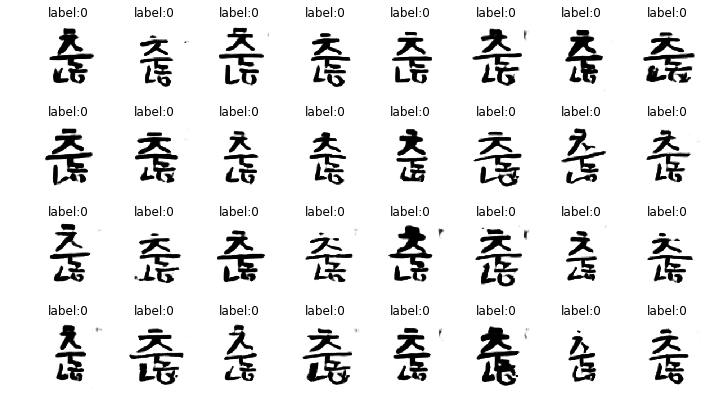

In [139]:
test_fake_2 = Generator(test_source_2, En, De, embeddings, test_label_2, GPU=GPU)[0]

plt.figure(figsize=(12, 7))
for idx, image in enumerate(test_fake_2):
    plt.subplot(4, 8, idx+1)
    plt.imshow(image.reshape(128, 128).cpu().detach().numpy(), cmap='gray')
    plt.title("label:" + str(int(test_label_2[idx].cpu().data)))
    plt.axis('off')
plt.show()

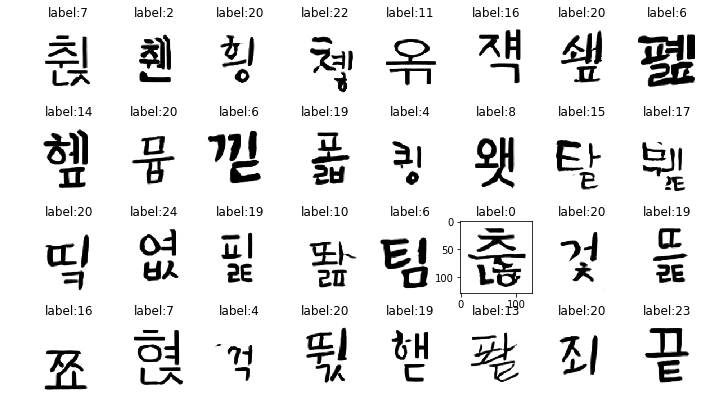

In [129]:
fixed_fake = Generator(fixed_sources[-1], En, De, embeddings, fixed_labels[-1], GPU=GPU)[0]

plt.figure(figsize=(12, 7))
for idx, image in enumerate(fixed_fake):
    plt.subplot(4, 8, idx+1)
    plt.imshow(image.reshape(128, 128).cpu().detach().numpy(), cmap='gray')
    plt.title("label:" + str(int(fixed_labels[-1][idx].cpu().data)))
    if idx != 21:
        plt.axis('off')
plt.show()

- 진짜 너무 이해가 안되는데. label이 똑같은데 대체 왜 다른 결과가 나오지?

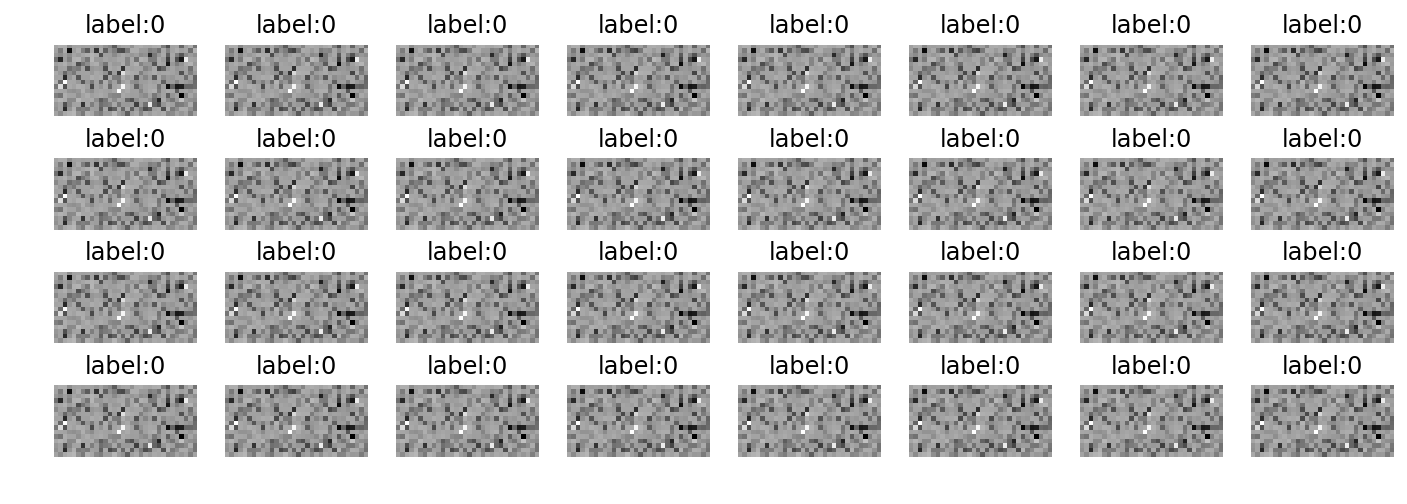

In [180]:
encoded_source_2, encode_layers_2 = En(test_source_2)
encoded_source_pic_2 = encoded_source_2.squeeze().view(32, 16, 32)

plt.figure(figsize=(12, 4))
for idx, image in enumerate(encoded_source_pic_2):
    plt.subplot(4, 8, idx+1)
    plt.imshow(image.cpu().detach().numpy(), cmap='gray')
    plt.title("label:" + str(int(test_label_2[idx].cpu().data)))
    plt.axis('off')
plt.show()

In [197]:
for i in range(32):
    print(np.sum(encoded_source_2[i].cpu().detach().numpy()), end="\t")
    if (i+1) % 4 == 0:
        print("")

-149.97647	-149.66843	-149.97647	-149.66843	
-149.97647	-149.66843	-149.97647	-149.66843	
-149.97647	-149.66843	-149.97647	-149.66843	
-149.97647	-149.66843	-149.97647	-149.66843	
-149.97647	-149.66843	-149.97647	-149.66843	
-149.97647	-149.66843	-149.97647	-149.66843	
-149.97647	-149.66843	-149.97647	-149.66843	
-149.97647	-149.66843	-149.97647	-149.66843	


In [204]:
print(encoded_source_2[0][:5].squeeze().data)
print(encoded_source_2[2][:5].squeeze().data)

tensor([-0.1574, -0.1058, -0.1030, -0.3052, -0.1879], device='cuda:0')
tensor([-0.1574, -0.1058, -0.1030, -0.3052, -0.1879], device='cuda:0')


In [205]:
print(encoded_source_2[1][:5].squeeze().data)
print(encoded_source_2[3][:5].squeeze().data)

tensor([-0.1852, -0.1070, -0.1011, -0.3318, -0.1904], device='cuda:0')
tensor([-0.1852, -0.1070, -0.1011, -0.3318, -0.1904], device='cuda:0')


---

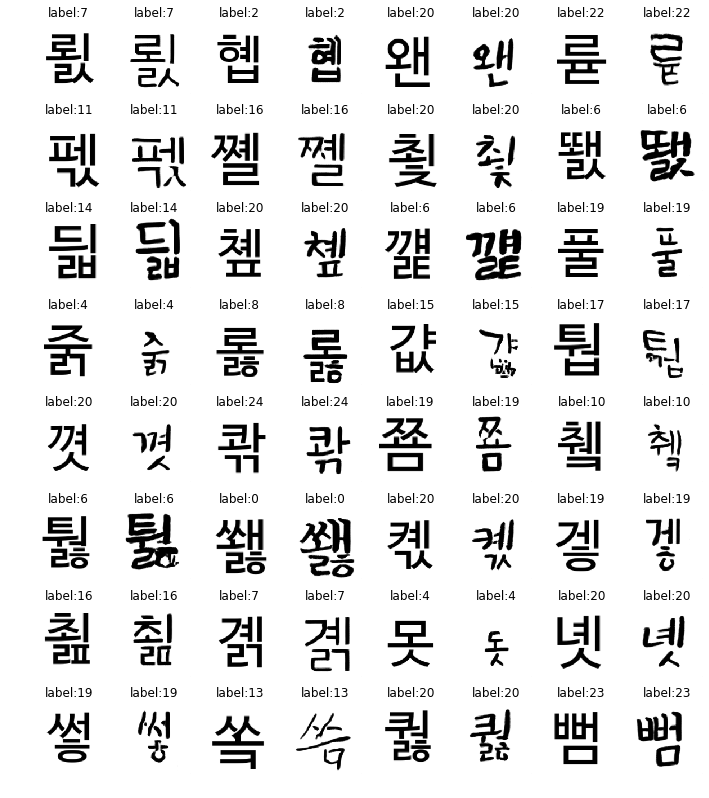

In [154]:
fixed_source = fixed_sources[0]

fixed_fake_images_1 = Generator(fixed_source, En, De, embeddings, fixed_labels[-1], GPU=GPU)[0]

plt.figure(figsize=(12, 14))
for idx, (image, source) in enumerate(zip(fixed_fake_images_1, fixed_source)):
    plt.subplot(8, 8, 2*idx+1)
    plt.imshow(source.reshape(128, 128).cpu().detach().numpy(), cmap='gray')
    plt.title("label:" + str(int(fixed_labels[-1][idx].cpu().data)))
    plt.axis('off')
    
    plt.subplot(8, 8, 2*idx+2)
    plt.imshow(image.reshape(128, 128).cpu().detach().numpy(), cmap='gray')
    plt.title("label:" + str(int(fixed_labels[-1][idx].cpu().data)))
    plt.axis('off')
plt.show()